### Rishu Raj Singh (2023AIB2080)

### Configuration 1

In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 773.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00


In [2]:
import math
from dataclasses import dataclass
import os
import numpy as np
import sacrebleu
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
SRC = "en"
TRG = "fr"
en_vocab_size = 8000
fr_vocab_size = 8000
vocab_sizes = {"en": en_vocab_size, "fr": fr_vocab_size}
max_seq_len = 72

In [4]:
full_set = pandas.read_csv("/kaggle/input/dataset-5/eng_-french.csv")

temp_train_set, test_set = train_test_split(full_set, test_size=0.3, random_state=42)
full_train_set, valid_set = train_test_split(temp_train_set, test_size=0.1, random_state=42)

print(len(full_train_set), len(valid_set), len(test_set))

110640 12294 52687


In [5]:
full_train_set.head(3)

,English words/sentences,French words/sentences
1660,That hurts.,Ça fait mal.
89279,I can't function without you.,Je n'arrive pas à fonctionner sans toi.
144858,Let's talk about what you did in Boston.,Parlons de ce que tu as fait à Boston.


In [6]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders

# This library has been used only for tokenization purpose because French sentences contains 
# distinct type of character which is diificult to capture normally.

def get_tokenizers(dataset, train_set_size):
    en_sentences = dataset['English words/sentences'].iloc[:train_set_size].tolist()
    fr_sentences = dataset['French words/sentences'].iloc[:train_set_size].tolist()

    # Write English and French sentences to temporary files
    en_file = 'temp_en_sentences.txt'
    fr_file = 'temp_fr_sentences.txt'
    with open(en_file, 'w', encoding='utf-8') as f_en, open(fr_file, 'w', encoding='utf-8') as f_fr:
        for en_sent, fr_sent in zip(en_sentences, fr_sentences):
            f_en.write(en_sent + '\n')
            f_fr.write(fr_sent + '\n')

    # Initialize a tokenizer
    en_tokenizer = Tokenizer(models.BPE())
    fr_tokenizer = Tokenizer(models.BPE())

    # Customize pre-tokenization and decoding
    en_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    fr_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    en_tokenizer.decoder = decoders.BPEDecoder()
    fr_tokenizer.decoder = decoders.BPEDecoder()

    en_tokenizer.train([en_file], trainer=trainers.BpeTrainer(vocab_size=en_vocab_size, special_tokens=["<pad>"]))
    fr_tokenizer.train([fr_file], trainer=trainers.BpeTrainer(vocab_size=fr_vocab_size, special_tokens=["<pad>"]))

    # Define the tokenization and detokenization functions
    tokenizers = {"en": lambda sent: en_tokenizer.encode(sent).ids, "fr": lambda sent: fr_tokenizer.encode(sent).ids}
    detokenizers = {"en": lambda ids: ' '.join([en_tokenizer.id_to_token(id) for id in ids]), 
                    "fr": lambda ids: ' '.join([fr_tokenizer.id_to_token(id) for id in ids])}
    # Cleanup temporary files
    os.remove(en_file)
    os.remove(fr_file)

    return tokenizers, detokenizers


In [7]:
tokenizers, detokenizers = get_tokenizers(full_train_set, len(full_set))
print(tokenizers['fr']("De quoi ai-je l'air ?"))
print(tokenizers['en']('How do I look?'))

# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3







[645, 238, 106, 10, 167, 63, 6, 488, 25]
[238, 114, 32, 274, 23]


In [8]:
def tokenize_dataset(dataset):
    """
    Tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences.
    """
    if SRC == "en":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    

class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded

In [9]:
batch_size = 16

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self):
        # train_set = list(full_train_set)[0:train_set_size]
        train_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in full_train_set.iterrows()]
        valid_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in valid_set.iterrows()]
        test_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in test_set.iterrows()]
        # print(train_set)
        train_dataset = TranslationDataset(tokenize_dataset(train_set_1))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set_1))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set_1))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
    '''residual connection: x + dropout(sublayer(layernorm(x))) '''
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_embed, max_seq_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_embed = d_embed
        # Compute the positional encodings in log space
        pe = torch.zeros(max_seq_len, d_embed)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2).float() * (-math.log(10000.0) / d_embed))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encodings to the input embeddings
        return x + self.pe[:, :x.size(1), :]


class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)



class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)


In [11]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [12]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

In [13]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses = []
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y) in pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        losses.append(loss.item())
        # report progress
        if idx > 0 and idx % 50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}')
    return np.mean(losses)


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

def compute_accuracy(model, dataloader):
    'compute the validation accuracy'
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = torch.argmax(pred, dim=-1)  # Get the indices of the maximum value along the last dimension
            # Flatten trg_out to match pred for comparison
            trg_out_flat = trg_out.view(-1)
            correct = (pred.view(-1) == trg_out_flat).sum().item()
            total_correct += correct
            total_samples += trg_out_flat.size(0)
    accuracy = total_correct / total_samples
    return accuracy

In [14]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=128,
                     d_ff=1024,
                     h=1,
                     N_encoder=3,
                     N_decoder=3,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )


# Initialize model
model = make_model(config)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataloaders = Dataloaders()

# Set up training loop
num_epochs = 200
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):

    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader) * batch_size
    train_loss = train_epoch(model, dataloaders)
    train_losses.append(train_loss)
    valid_loss = validate(model, dataloaders.valid_loader)
    valid_losses.append(valid_loss)

    # Calculate validation accuracy
    valid_accuracy = compute_accuracy(model, dataloaders.valid_loader)
    valid_accuracies.append(valid_accuracy)


    print(f'ep:{epoch+1} train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, valid_accuracy={valid_accuracy:.5f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


# print("train set examples:")
# train_bleu = evaluate(model, dataloaders.train_loader, 20)
# print("validation set examples:")
# valid_bleu = evaluate(model, dataloaders.valid_loader)
# print("test set examples:")
# test_bleu  = evaluate(model, dataloaders.test_loader)


train loss=2.388: 100%|██████████| 6915/6915 [02:55<00:00, 39.51it/s]


ep:1 train_loss=2.82825, valid_loss=2.28178, valid_accuracy=0.64939


train loss=2.378: 100%|██████████| 6915/6915 [02:53<00:00, 39.91it/s]


ep:2 train_loss=2.14908, valid_loss=1.94630, valid_accuracy=0.68124


train loss=1.718: 100%|██████████| 6915/6915 [02:53<00:00, 39.80it/s]


ep:3 train_loss=1.87740, valid_loss=1.70783, valid_accuracy=0.70681


train loss=1.528: 100%|██████████| 6915/6915 [02:54<00:00, 39.57it/s]


ep:4 train_loss=1.67656, valid_loss=1.51227, valid_accuracy=0.73059


train loss=1.562: 100%|██████████| 6915/6915 [02:54<00:00, 39.60it/s]


ep:5 train_loss=1.50871, valid_loss=1.36293, valid_accuracy=0.75231


train loss=1.633: 100%|██████████| 6915/6915 [02:54<00:00, 39.74it/s]


ep:6 train_loss=1.36771, valid_loss=1.24135, valid_accuracy=0.76922


train loss=1.448: 100%|██████████| 6915/6915 [02:54<00:00, 39.68it/s]


ep:7 train_loss=1.24841, valid_loss=1.13761, valid_accuracy=0.78498


train loss=1.003: 100%|██████████| 6915/6915 [02:54<00:00, 39.74it/s]


ep:8 train_loss=1.14983, valid_loss=1.05926, valid_accuracy=0.79774


train loss=1.053: 100%|██████████| 6915/6915 [02:54<00:00, 39.53it/s]


ep:9 train_loss=1.06717, valid_loss=1.00346, valid_accuracy=0.80706


train loss=1.077: 100%|██████████| 6915/6915 [02:54<00:00, 39.63it/s]


ep:10 train_loss=0.99893, valid_loss=0.94947, valid_accuracy=0.81479


train loss=1.007: 100%|██████████| 6915/6915 [02:55<00:00, 39.39it/s]


ep:11 train_loss=0.94470, valid_loss=0.90211, valid_accuracy=0.82206


train loss=0.790: 100%|██████████| 6915/6915 [02:53<00:00, 39.93it/s]


ep:12 train_loss=0.89562, valid_loss=0.86816, valid_accuracy=0.82722


train loss=0.891: 100%|██████████| 6915/6915 [02:55<00:00, 39.43it/s]


ep:13 train_loss=0.85298, valid_loss=0.84249, valid_accuracy=0.83135


train loss=0.881: 100%|██████████| 6915/6915 [02:55<00:00, 39.31it/s]


ep:14 train_loss=0.81320, valid_loss=0.81253, valid_accuracy=0.83694


train loss=0.698: 100%|██████████| 6915/6915 [02:54<00:00, 39.55it/s]


ep:15 train_loss=0.78226, valid_loss=0.79067, valid_accuracy=0.84031


train loss=0.939: 100%|██████████| 6915/6915 [02:54<00:00, 39.63it/s]


ep:16 train_loss=0.75558, valid_loss=0.76982, valid_accuracy=0.84457


train loss=0.554: 100%|██████████| 6915/6915 [02:54<00:00, 39.57it/s]


ep:17 train_loss=0.72698, valid_loss=0.75589, valid_accuracy=0.84789


train loss=0.606: 100%|██████████| 6915/6915 [02:54<00:00, 39.74it/s]


ep:18 train_loss=0.70317, valid_loss=0.73782, valid_accuracy=0.85013


train loss=0.629: 100%|██████████| 6915/6915 [02:55<00:00, 39.33it/s]


ep:19 train_loss=0.68178, valid_loss=0.72516, valid_accuracy=0.85149


train loss=1.070: 100%|██████████| 6915/6915 [02:55<00:00, 39.49it/s]


ep:20 train_loss=0.66331, valid_loss=0.71594, valid_accuracy=0.85415


train loss=0.526: 100%|██████████| 6915/6915 [02:55<00:00, 39.47it/s]


ep:21 train_loss=0.64385, valid_loss=0.70215, valid_accuracy=0.85653


train loss=0.746: 100%|██████████| 6915/6915 [02:52<00:00, 39.98it/s]


ep:22 train_loss=0.62945, valid_loss=0.69590, valid_accuracy=0.85802


train loss=0.459: 100%|██████████| 6915/6915 [02:55<00:00, 39.36it/s]


ep:23 train_loss=0.61507, valid_loss=0.69028, valid_accuracy=0.85967


train loss=0.499: 100%|██████████| 6915/6915 [02:56<00:00, 39.23it/s]


ep:24 train_loss=0.60038, valid_loss=0.67880, valid_accuracy=0.86187


train loss=0.598: 100%|██████████| 6915/6915 [02:55<00:00, 39.51it/s]


ep:25 train_loss=0.58745, valid_loss=0.66999, valid_accuracy=0.86247


train loss=0.524: 100%|██████████| 6915/6915 [02:54<00:00, 39.67it/s]


ep:26 train_loss=0.57616, valid_loss=0.66895, valid_accuracy=0.86380


train loss=0.351: 100%|██████████| 6915/6915 [02:55<00:00, 39.44it/s]


ep:27 train_loss=0.56330, valid_loss=0.66136, valid_accuracy=0.86479


train loss=0.773: 100%|██████████| 6915/6915 [02:55<00:00, 39.45it/s]


ep:28 train_loss=0.55299, valid_loss=0.65385, valid_accuracy=0.86591


train loss=0.295: 100%|██████████| 6915/6915 [02:55<00:00, 39.44it/s]


ep:29 train_loss=0.54204, valid_loss=0.65463, valid_accuracy=0.86652


train loss=0.517: 100%|██████████| 6915/6915 [02:54<00:00, 39.52it/s]


ep:30 train_loss=0.53282, valid_loss=0.64782, valid_accuracy=0.86712


train loss=0.753: 100%|██████████| 6915/6915 [02:55<00:00, 39.46it/s]


ep:31 train_loss=0.52380, valid_loss=0.64128, valid_accuracy=0.86806


train loss=0.410: 100%|██████████| 6915/6915 [02:55<00:00, 39.46it/s]


ep:32 train_loss=0.51712, valid_loss=0.63942, valid_accuracy=0.86980


train loss=0.377: 100%|██████████| 6915/6915 [02:56<00:00, 39.17it/s]


ep:33 train_loss=0.50796, valid_loss=0.63725, valid_accuracy=0.86980


train loss=0.510: 100%|██████████| 6915/6915 [02:54<00:00, 39.54it/s]


ep:34 train_loss=0.49900, valid_loss=0.63506, valid_accuracy=0.87021


train loss=0.357: 100%|██████████| 6915/6915 [02:54<00:00, 39.61it/s]


ep:35 train_loss=0.49262, valid_loss=0.62853, valid_accuracy=0.87106


train loss=0.659: 100%|██████████| 6915/6915 [02:54<00:00, 39.59it/s]


ep:36 train_loss=0.48731, valid_loss=0.62568, valid_accuracy=0.87179


train loss=0.472: 100%|██████████| 6915/6915 [02:56<00:00, 39.07it/s]


ep:37 train_loss=0.47932, valid_loss=0.62693, valid_accuracy=0.87210


train loss=0.424: 100%|██████████| 6915/6915 [02:56<00:00, 39.11it/s]


ep:38 train_loss=0.47391, valid_loss=0.62173, valid_accuracy=0.87304


train loss=0.385: 100%|██████████| 6915/6915 [02:55<00:00, 39.38it/s]


ep:39 train_loss=0.46569, valid_loss=0.61992, valid_accuracy=0.87319


train loss=0.487: 100%|██████████| 6915/6915 [02:56<00:00, 39.18it/s]


ep:40 train_loss=0.46070, valid_loss=0.61721, valid_accuracy=0.87360


train loss=0.341: 100%|██████████| 6915/6915 [02:56<00:00, 39.29it/s]


ep:41 train_loss=0.45599, valid_loss=0.61761, valid_accuracy=0.87482


train loss=0.321: 100%|██████████| 6915/6915 [02:55<00:00, 39.37it/s]


ep:42 train_loss=0.44909, valid_loss=0.61939, valid_accuracy=0.87477


train loss=0.354: 100%|██████████| 6915/6915 [02:56<00:00, 39.18it/s]


ep:43 train_loss=0.44401, valid_loss=0.61484, valid_accuracy=0.87534


train loss=0.401: 100%|██████████| 6915/6915 [02:54<00:00, 39.52it/s]


ep:44 train_loss=0.43968, valid_loss=0.61490, valid_accuracy=0.87621


train loss=0.391: 100%|██████████| 6915/6915 [02:57<00:00, 39.02it/s]


ep:45 train_loss=0.43492, valid_loss=0.61556, valid_accuracy=0.87509


train loss=0.427: 100%|██████████| 6915/6915 [02:54<00:00, 39.60it/s]


ep:46 train_loss=0.42962, valid_loss=0.61062, valid_accuracy=0.87594


train loss=0.383: 100%|██████████| 6915/6915 [02:54<00:00, 39.71it/s]


ep:47 train_loss=0.42499, valid_loss=0.61287, valid_accuracy=0.87626


train loss=0.570: 100%|██████████| 6915/6915 [02:54<00:00, 39.52it/s]


ep:48 train_loss=0.42192, valid_loss=0.60821, valid_accuracy=0.87748


train loss=0.488: 100%|██████████| 6915/6915 [02:54<00:00, 39.61it/s]


ep:49 train_loss=0.41619, valid_loss=0.60973, valid_accuracy=0.87675


train loss=0.406: 100%|██████████| 6915/6915 [02:55<00:00, 39.41it/s]


ep:50 train_loss=0.41261, valid_loss=0.61033, valid_accuracy=0.87810


train loss=0.427: 100%|██████████| 6915/6915 [02:56<00:00, 39.28it/s]


ep:51 train_loss=0.40850, valid_loss=0.60348, valid_accuracy=0.87776


train loss=0.435: 100%|██████████| 6915/6915 [02:54<00:00, 39.66it/s]


ep:52 train_loss=0.40423, valid_loss=0.61038, valid_accuracy=0.87821


train loss=0.538: 100%|██████████| 6915/6915 [02:55<00:00, 39.36it/s]


ep:53 train_loss=0.40186, valid_loss=0.61171, valid_accuracy=0.87725


train loss=0.394: 100%|██████████| 6915/6915 [02:56<00:00, 39.28it/s]


ep:54 train_loss=0.39742, valid_loss=0.60609, valid_accuracy=0.87761


train loss=0.448: 100%|██████████| 6915/6915 [02:56<00:00, 39.25it/s]


ep:55 train_loss=0.39372, valid_loss=0.60805, valid_accuracy=0.87858


train loss=0.555: 100%|██████████| 6915/6915 [02:54<00:00, 39.57it/s]


ep:56 train_loss=0.39022, valid_loss=0.60424, valid_accuracy=0.87849


train loss=0.196: 100%|██████████| 6915/6915 [02:54<00:00, 39.52it/s]


ep:57 train_loss=0.38714, valid_loss=0.60367, valid_accuracy=0.87901


train loss=0.306: 100%|██████████| 6915/6915 [02:56<00:00, 39.21it/s]


ep:58 train_loss=0.38277, valid_loss=0.60038, valid_accuracy=0.87935


train loss=0.306: 100%|██████████| 6915/6915 [02:53<00:00, 39.76it/s]


ep:59 train_loss=0.38104, valid_loss=0.60349, valid_accuracy=0.88004


train loss=0.507: 100%|██████████| 6915/6915 [02:54<00:00, 39.67it/s]


ep:60 train_loss=0.37747, valid_loss=0.60436, valid_accuracy=0.87972


train loss=0.582: 100%|██████████| 6915/6915 [02:55<00:00, 39.42it/s]


ep:61 train_loss=0.37405, valid_loss=0.60550, valid_accuracy=0.87993


train loss=0.334: 100%|██████████| 6915/6915 [02:55<00:00, 39.34it/s]


ep:62 train_loss=0.37132, valid_loss=0.60603, valid_accuracy=0.88043


train loss=0.402: 100%|██████████| 6915/6915 [02:56<00:00, 39.26it/s]


ep:63 train_loss=0.36813, valid_loss=0.60397, valid_accuracy=0.88022


train loss=0.414: 100%|██████████| 6915/6915 [02:54<00:00, 39.56it/s]


ep:64 train_loss=0.36591, valid_loss=0.59961, valid_accuracy=0.88046


train loss=0.360: 100%|██████████| 6915/6915 [02:53<00:00, 39.91it/s]


ep:65 train_loss=0.36249, valid_loss=0.60483, valid_accuracy=0.88035


train loss=0.302: 100%|██████████| 6915/6915 [02:56<00:00, 39.14it/s]


ep:66 train_loss=0.35937, valid_loss=0.60047, valid_accuracy=0.88100


train loss=0.388: 100%|██████████| 6915/6915 [02:54<00:00, 39.66it/s]


ep:67 train_loss=0.35744, valid_loss=0.60630, valid_accuracy=0.88146


train loss=0.320: 100%|██████████| 6915/6915 [02:56<00:00, 39.27it/s]


ep:68 train_loss=0.35466, valid_loss=0.60075, valid_accuracy=0.88173


train loss=0.555: 100%|██████████| 6915/6915 [02:56<00:00, 39.28it/s]


ep:69 train_loss=0.35322, valid_loss=0.60382, valid_accuracy=0.88047


train loss=0.150: 100%|██████████| 6915/6915 [02:54<00:00, 39.72it/s]


ep:70 train_loss=0.34989, valid_loss=0.60927, valid_accuracy=0.88089


train loss=0.340: 100%|██████████| 6915/6915 [02:56<00:00, 39.23it/s]


ep:71 train_loss=0.34705, valid_loss=0.60666, valid_accuracy=0.88202


train loss=0.365: 100%|██████████| 6915/6915 [02:55<00:00, 39.36it/s]


ep:72 train_loss=0.34479, valid_loss=0.60706, valid_accuracy=0.88277


train loss=0.296: 100%|██████████| 6915/6915 [02:55<00:00, 39.49it/s]


ep:73 train_loss=0.34309, valid_loss=0.60516, valid_accuracy=0.88231


train loss=0.404: 100%|██████████| 6915/6915 [02:54<00:00, 39.71it/s]


ep:74 train_loss=0.34035, valid_loss=0.60076, valid_accuracy=0.88263


train loss=0.379: 100%|██████████| 6915/6915 [02:54<00:00, 39.69it/s]


ep:75 train_loss=0.33837, valid_loss=0.60001, valid_accuracy=0.88200


train loss=0.260: 100%|██████████| 6915/6915 [02:53<00:00, 39.74it/s]


ep:76 train_loss=0.33658, valid_loss=0.60543, valid_accuracy=0.88118


train loss=0.345: 100%|██████████| 6915/6915 [02:54<00:00, 39.53it/s]


ep:77 train_loss=0.33345, valid_loss=0.60511, valid_accuracy=0.88188


train loss=0.413: 100%|██████████| 6915/6915 [02:56<00:00, 39.09it/s]


ep:78 train_loss=0.33182, valid_loss=0.60578, valid_accuracy=0.88259


train loss=0.333: 100%|██████████| 6915/6915 [02:57<00:00, 39.04it/s]


ep:79 train_loss=0.33037, valid_loss=0.60892, valid_accuracy=0.88290


train loss=0.254: 100%|██████████| 6915/6915 [02:55<00:00, 39.30it/s]


ep:80 train_loss=0.32802, valid_loss=0.60636, valid_accuracy=0.88294


train loss=0.358: 100%|██████████| 6915/6915 [02:57<00:00, 38.89it/s]


ep:81 train_loss=0.32550, valid_loss=0.60247, valid_accuracy=0.88288


train loss=0.502: 100%|██████████| 6915/6915 [02:53<00:00, 39.76it/s]


ep:82 train_loss=0.32410, valid_loss=0.60432, valid_accuracy=0.88277


train loss=0.210: 100%|██████████| 6915/6915 [02:59<00:00, 38.61it/s]


ep:83 train_loss=0.32176, valid_loss=0.61107, valid_accuracy=0.88308


train loss=0.323: 100%|██████████| 6915/6915 [02:54<00:00, 39.61it/s]


ep:84 train_loss=0.32012, valid_loss=0.61049, valid_accuracy=0.88268


train loss=0.478: 100%|██████████| 6915/6915 [02:55<00:00, 39.49it/s]


ep:85 train_loss=0.31945, valid_loss=0.60775, valid_accuracy=0.88350


train loss=0.321: 100%|██████████| 6915/6915 [02:55<00:00, 39.46it/s]


ep:86 train_loss=0.31606, valid_loss=0.60358, valid_accuracy=0.88366


train loss=0.412: 100%|██████████| 6915/6915 [02:54<00:00, 39.64it/s]


ep:87 train_loss=0.31387, valid_loss=0.60765, valid_accuracy=0.88329


train loss=0.445: 100%|██████████| 6915/6915 [02:54<00:00, 39.57it/s]


ep:88 train_loss=0.31331, valid_loss=0.60616, valid_accuracy=0.88315


train loss=0.411: 100%|██████████| 6915/6915 [02:56<00:00, 39.15it/s]


ep:89 train_loss=0.31084, valid_loss=0.60949, valid_accuracy=0.88318


train loss=0.382: 100%|██████████| 6915/6915 [02:53<00:00, 39.84it/s]


ep:90 train_loss=0.31004, valid_loss=0.60618, valid_accuracy=0.88431


train loss=0.384: 100%|██████████| 6915/6915 [02:56<00:00, 39.28it/s]


ep:91 train_loss=0.30716, valid_loss=0.60573, valid_accuracy=0.88392


train loss=0.360: 100%|██████████| 6915/6915 [02:54<00:00, 39.55it/s]


ep:92 train_loss=0.30637, valid_loss=0.61184, valid_accuracy=0.88382


train loss=0.183: 100%|██████████| 6915/6915 [02:55<00:00, 39.46it/s]


ep:93 train_loss=0.30445, valid_loss=0.60713, valid_accuracy=0.88451


train loss=0.327: 100%|██████████| 6915/6915 [02:54<00:00, 39.70it/s]


ep:94 train_loss=0.30302, valid_loss=0.60797, valid_accuracy=0.88471


train loss=0.238: 100%|██████████| 6915/6915 [02:54<00:00, 39.52it/s]


ep:95 train_loss=0.30144, valid_loss=0.60443, valid_accuracy=0.88346


train loss=0.347: 100%|██████████| 6915/6915 [02:55<00:00, 39.41it/s]


ep:96 train_loss=0.30021, valid_loss=0.61066, valid_accuracy=0.88304


train loss=0.245: 100%|██████████| 6915/6915 [02:54<00:00, 39.71it/s]


ep:97 train_loss=0.29870, valid_loss=0.61645, valid_accuracy=0.88424


train loss=0.265: 100%|██████████| 6915/6915 [02:55<00:00, 39.49it/s]


ep:98 train_loss=0.29681, valid_loss=0.61146, valid_accuracy=0.88354


train loss=0.358: 100%|██████████| 6915/6915 [02:53<00:00, 39.96it/s]


ep:99 train_loss=0.29666, valid_loss=0.61251, valid_accuracy=0.88426


train loss=0.316: 100%|██████████| 6915/6915 [02:54<00:00, 39.64it/s]


ep:100 train_loss=0.29413, valid_loss=0.61327, valid_accuracy=0.88326


train loss=0.260: 100%|██████████| 6915/6915 [02:53<00:00, 39.78it/s]


ep:101 train_loss=0.29284, valid_loss=0.61479, valid_accuracy=0.88492


train loss=0.230: 100%|██████████| 6915/6915 [02:54<00:00, 39.52it/s]


ep:102 train_loss=0.29059, valid_loss=0.61353, valid_accuracy=0.88311


train loss=0.266: 100%|██████████| 6915/6915 [02:54<00:00, 39.65it/s]


ep:103 train_loss=0.28963, valid_loss=0.61417, valid_accuracy=0.88477


train loss=0.281: 100%|██████████| 6915/6915 [02:54<00:00, 39.68it/s]


ep:104 train_loss=0.28882, valid_loss=0.61345, valid_accuracy=0.88390


train loss=0.267: 100%|██████████| 6915/6915 [02:55<00:00, 39.42it/s]


ep:105 train_loss=0.28733, valid_loss=0.61556, valid_accuracy=0.88434


train loss=0.293: 100%|██████████| 6915/6915 [02:53<00:00, 39.90it/s]


ep:106 train_loss=0.28637, valid_loss=0.61314, valid_accuracy=0.88465


train loss=0.384: 100%|██████████| 6915/6915 [02:53<00:00, 39.90it/s]


ep:107 train_loss=0.28498, valid_loss=0.61625, valid_accuracy=0.88423


train loss=0.498: 100%|██████████| 6915/6915 [02:56<00:00, 39.22it/s]


ep:108 train_loss=0.28318, valid_loss=0.61836, valid_accuracy=0.88486


train loss=0.297: 100%|██████████| 6915/6915 [02:53<00:00, 39.97it/s]


ep:109 train_loss=0.28247, valid_loss=0.61717, valid_accuracy=0.88400


train loss=0.328: 100%|██████████| 6915/6915 [02:54<00:00, 39.57it/s]


ep:110 train_loss=0.27987, valid_loss=0.61931, valid_accuracy=0.88451


train loss=0.373: 100%|██████████| 6915/6915 [02:54<00:00, 39.55it/s]


ep:111 train_loss=0.28005, valid_loss=0.61738, valid_accuracy=0.88417


train loss=0.334: 100%|██████████| 6915/6915 [02:53<00:00, 39.86it/s]


ep:112 train_loss=0.27879, valid_loss=0.62114, valid_accuracy=0.88428


train loss=0.203: 100%|██████████| 6915/6915 [02:55<00:00, 39.47it/s]


ep:113 train_loss=0.27657, valid_loss=0.61860, valid_accuracy=0.88369


train loss=0.215: 100%|██████████| 6915/6915 [02:53<00:00, 39.92it/s]


ep:114 train_loss=0.27641, valid_loss=0.61713, valid_accuracy=0.88520


train loss=0.363: 100%|██████████| 6915/6915 [02:53<00:00, 39.90it/s]


ep:115 train_loss=0.27488, valid_loss=0.61978, valid_accuracy=0.88573


train loss=0.388: 100%|██████████| 6915/6915 [02:53<00:00, 39.82it/s]


ep:116 train_loss=0.27391, valid_loss=0.62002, valid_accuracy=0.88474


train loss=0.470: 100%|██████████| 6915/6915 [02:56<00:00, 39.23it/s]


ep:117 train_loss=0.27176, valid_loss=0.61681, valid_accuracy=0.88493


train loss=0.165: 100%|██████████| 6915/6915 [02:54<00:00, 39.55it/s]


ep:118 train_loss=0.27132, valid_loss=0.61949, valid_accuracy=0.88520


train loss=0.162: 100%|██████████| 6915/6915 [02:53<00:00, 39.96it/s]


ep:119 train_loss=0.27067, valid_loss=0.62467, valid_accuracy=0.88543


train loss=0.341: 100%|██████████| 6915/6915 [02:56<00:00, 39.29it/s]


ep:120 train_loss=0.26962, valid_loss=0.61621, valid_accuracy=0.88510


train loss=0.290: 100%|██████████| 6915/6915 [02:54<00:00, 39.64it/s]


ep:121 train_loss=0.26786, valid_loss=0.62214, valid_accuracy=0.88453


train loss=0.282: 100%|██████████| 6915/6915 [02:55<00:00, 39.49it/s]


ep:122 train_loss=0.26687, valid_loss=0.62281, valid_accuracy=0.88626


train loss=0.268: 100%|██████████| 6915/6915 [02:54<00:00, 39.53it/s]


ep:123 train_loss=0.26666, valid_loss=0.62128, valid_accuracy=0.88631


train loss=0.264: 100%|██████████| 6915/6915 [02:56<00:00, 39.27it/s]


ep:124 train_loss=0.26529, valid_loss=0.62565, valid_accuracy=0.88468


train loss=0.288: 100%|██████████| 6915/6915 [02:54<00:00, 39.55it/s]


ep:125 train_loss=0.26474, valid_loss=0.61643, valid_accuracy=0.88590


train loss=0.128: 100%|██████████| 6915/6915 [02:55<00:00, 39.39it/s]


ep:126 train_loss=0.26258, valid_loss=0.62055, valid_accuracy=0.88606


train loss=0.324: 100%|██████████| 6915/6915 [02:54<00:00, 39.56it/s]


ep:127 train_loss=0.26164, valid_loss=0.62528, valid_accuracy=0.88496


train loss=0.343: 100%|██████████| 6915/6915 [02:55<00:00, 39.46it/s]


ep:128 train_loss=0.26062, valid_loss=0.62639, valid_accuracy=0.88548


train loss=0.192: 100%|██████████| 6915/6915 [02:53<00:00, 39.85it/s]


ep:129 train_loss=0.25905, valid_loss=0.62327, valid_accuracy=0.88544


train loss=0.222: 100%|██████████| 6915/6915 [02:54<00:00, 39.71it/s]


ep:130 train_loss=0.25865, valid_loss=0.62819, valid_accuracy=0.88589


train loss=0.191: 100%|██████████| 6915/6915 [02:53<00:00, 39.77it/s]


ep:131 train_loss=0.25819, valid_loss=0.62601, valid_accuracy=0.88525


train loss=0.350: 100%|██████████| 6915/6915 [02:55<00:00, 39.47it/s]


ep:132 train_loss=0.25709, valid_loss=0.62802, valid_accuracy=0.88542


train loss=0.269: 100%|██████████| 6915/6915 [02:53<00:00, 39.76it/s]


ep:133 train_loss=0.25599, valid_loss=0.62794, valid_accuracy=0.88540


train loss=0.157: 100%|██████████| 6915/6915 [02:53<00:00, 39.86it/s]


ep:134 train_loss=0.25487, valid_loss=0.63066, valid_accuracy=0.88519


train loss=0.249: 100%|██████████| 6915/6915 [02:54<00:00, 39.68it/s]


ep:135 train_loss=0.25418, valid_loss=0.62750, valid_accuracy=0.88547


train loss=0.364: 100%|██████████| 6915/6915 [02:52<00:00, 40.00it/s]


ep:136 train_loss=0.25346, valid_loss=0.62648, valid_accuracy=0.88596


train loss=0.152: 100%|██████████| 6915/6915 [02:52<00:00, 40.03it/s]


ep:137 train_loss=0.25285, valid_loss=0.62612, valid_accuracy=0.88571


train loss=0.222: 100%|██████████| 6915/6915 [02:52<00:00, 40.08it/s]


ep:138 train_loss=0.25100, valid_loss=0.62633, valid_accuracy=0.88608


train loss=0.319: 100%|██████████| 6915/6915 [02:55<00:00, 39.42it/s]


ep:139 train_loss=0.25069, valid_loss=0.63146, valid_accuracy=0.88663


train loss=0.191: 100%|██████████| 6915/6915 [02:54<00:00, 39.56it/s]


ep:140 train_loss=0.24957, valid_loss=0.63393, valid_accuracy=0.88609


train loss=0.185: 100%|██████████| 6915/6915 [02:54<00:00, 39.57it/s]


ep:141 train_loss=0.24790, valid_loss=0.62986, valid_accuracy=0.88532


train loss=0.273: 100%|██████████| 6915/6915 [02:55<00:00, 39.42it/s]


ep:142 train_loss=0.24812, valid_loss=0.62494, valid_accuracy=0.88589


train loss=0.191: 100%|██████████| 6915/6915 [02:55<00:00, 39.48it/s]


ep:143 train_loss=0.24679, valid_loss=0.63492, valid_accuracy=0.88571


train loss=0.217: 100%|██████████| 6915/6915 [02:53<00:00, 39.85it/s]


ep:144 train_loss=0.24613, valid_loss=0.63037, valid_accuracy=0.88652


train loss=0.236: 100%|██████████| 6915/6915 [02:53<00:00, 39.76it/s]


ep:145 train_loss=0.24595, valid_loss=0.63296, valid_accuracy=0.88567


train loss=0.174: 100%|██████████| 6915/6915 [02:55<00:00, 39.41it/s]


ep:146 train_loss=0.24520, valid_loss=0.63374, valid_accuracy=0.88698


train loss=0.312: 100%|██████████| 6915/6915 [02:55<00:00, 39.36it/s]


ep:147 train_loss=0.24473, valid_loss=0.63526, valid_accuracy=0.88601


train loss=0.187: 100%|██████████| 6915/6915 [02:53<00:00, 39.95it/s]


ep:148 train_loss=0.24312, valid_loss=0.63112, valid_accuracy=0.88655


train loss=0.243: 100%|██████████| 6915/6915 [02:54<00:00, 39.60it/s]


ep:149 train_loss=0.24219, valid_loss=0.63470, valid_accuracy=0.88587


train loss=0.249: 100%|██████████| 6915/6915 [02:54<00:00, 39.54it/s]


ep:150 train_loss=0.24216, valid_loss=0.63255, valid_accuracy=0.88600


train loss=0.279: 100%|██████████| 6915/6915 [02:55<00:00, 39.42it/s]


ep:151 train_loss=0.24127, valid_loss=0.63246, valid_accuracy=0.88634


train loss=0.169: 100%|██████████| 6915/6915 [02:56<00:00, 39.20it/s]


ep:152 train_loss=0.23973, valid_loss=0.63857, valid_accuracy=0.88689


train loss=0.247: 100%|██████████| 6915/6915 [02:56<00:00, 39.13it/s]


ep:153 train_loss=0.23906, valid_loss=0.63810, valid_accuracy=0.88664


train loss=0.308: 100%|██████████| 6915/6915 [02:53<00:00, 39.88it/s]


ep:154 train_loss=0.23889, valid_loss=0.63577, valid_accuracy=0.88684


train loss=0.270: 100%|██████████| 6915/6915 [02:54<00:00, 39.65it/s]


ep:155 train_loss=0.23777, valid_loss=0.63773, valid_accuracy=0.88621


train loss=0.328: 100%|██████████| 6915/6915 [02:55<00:00, 39.36it/s]


ep:156 train_loss=0.23676, valid_loss=0.64078, valid_accuracy=0.88649


train loss=0.328: 100%|██████████| 6915/6915 [02:55<00:00, 39.49it/s]


ep:157 train_loss=0.23671, valid_loss=0.63913, valid_accuracy=0.88634


train loss=0.290: 100%|██████████| 6915/6915 [02:54<00:00, 39.70it/s]


ep:158 train_loss=0.23562, valid_loss=0.63783, valid_accuracy=0.88628


train loss=0.155: 100%|██████████| 6915/6915 [02:55<00:00, 39.33it/s]


ep:159 train_loss=0.23530, valid_loss=0.64085, valid_accuracy=0.88612


train loss=0.285: 100%|██████████| 6915/6915 [02:56<00:00, 39.25it/s]


ep:160 train_loss=0.23489, valid_loss=0.64158, valid_accuracy=0.88695


train loss=0.239: 100%|██████████| 6915/6915 [02:54<00:00, 39.55it/s]


ep:161 train_loss=0.23393, valid_loss=0.63753, valid_accuracy=0.88652


train loss=0.284: 100%|██████████| 6915/6915 [02:54<00:00, 39.72it/s]


ep:162 train_loss=0.23273, valid_loss=0.63896, valid_accuracy=0.88714


train loss=0.174: 100%|██████████| 6915/6915 [02:56<00:00, 39.07it/s]


ep:163 train_loss=0.23289, valid_loss=0.64153, valid_accuracy=0.88640


train loss=0.208: 100%|██████████| 6915/6915 [02:53<00:00, 39.83it/s]


ep:164 train_loss=0.23217, valid_loss=0.63676, valid_accuracy=0.88706


train loss=0.255: 100%|██████████| 6915/6915 [02:56<00:00, 39.22it/s]


ep:165 train_loss=0.23119, valid_loss=0.64395, valid_accuracy=0.88668


train loss=0.237: 100%|██████████| 6915/6915 [02:56<00:00, 39.28it/s]


ep:166 train_loss=0.23020, valid_loss=0.64724, valid_accuracy=0.88731


train loss=0.289: 100%|██████████| 6915/6915 [03:00<00:00, 38.22it/s]


ep:167 train_loss=0.22941, valid_loss=0.64537, valid_accuracy=0.88776


train loss=0.240: 100%|██████████| 6915/6915 [02:53<00:00, 39.91it/s]


ep:168 train_loss=0.22860, valid_loss=0.64169, valid_accuracy=0.88683


train loss=0.230: 100%|██████████| 6915/6915 [02:55<00:00, 39.39it/s]


ep:169 train_loss=0.22857, valid_loss=0.64680, valid_accuracy=0.88647


train loss=0.260: 100%|██████████| 6915/6915 [02:54<00:00, 39.64it/s]


ep:170 train_loss=0.22756, valid_loss=0.64108, valid_accuracy=0.88659


train loss=0.173: 100%|██████████| 6915/6915 [02:55<00:00, 39.35it/s]


ep:171 train_loss=0.22700, valid_loss=0.63988, valid_accuracy=0.88751


train loss=0.295: 100%|██████████| 6915/6915 [02:54<00:00, 39.65it/s]


ep:172 train_loss=0.22616, valid_loss=0.64038, valid_accuracy=0.88598


train loss=0.282: 100%|██████████| 6915/6915 [02:54<00:00, 39.73it/s]


ep:173 train_loss=0.22521, valid_loss=0.64452, valid_accuracy=0.88769


train loss=0.231: 100%|██████████| 6915/6915 [02:55<00:00, 39.44it/s]


ep:174 train_loss=0.22523, valid_loss=0.64741, valid_accuracy=0.88682


train loss=0.302: 100%|██████████| 6915/6915 [02:55<00:00, 39.43it/s]


ep:175 train_loss=0.22496, valid_loss=0.64505, valid_accuracy=0.88688


train loss=0.214: 100%|██████████| 6915/6915 [02:55<00:00, 39.34it/s]


ep:176 train_loss=0.22324, valid_loss=0.64492, valid_accuracy=0.88721


train loss=0.290: 100%|██████████| 6915/6915 [02:54<00:00, 39.54it/s]


ep:177 train_loss=0.22312, valid_loss=0.64185, valid_accuracy=0.88658


train loss=0.296: 100%|██████████| 6915/6915 [02:56<00:00, 39.10it/s]


ep:178 train_loss=0.22166, valid_loss=0.64613, valid_accuracy=0.88744


train loss=0.115: 100%|██████████| 6915/6915 [02:54<00:00, 39.53it/s]


ep:179 train_loss=0.22149, valid_loss=0.64846, valid_accuracy=0.88609


train loss=0.228: 100%|██████████| 6915/6915 [02:56<00:00, 39.25it/s]


ep:180 train_loss=0.22202, valid_loss=0.64912, valid_accuracy=0.88596


train loss=0.172: 100%|██████████| 6915/6915 [02:55<00:00, 39.30it/s]


ep:181 train_loss=0.22078, valid_loss=0.64942, valid_accuracy=0.88719


train loss=0.371: 100%|██████████| 6915/6915 [02:52<00:00, 40.10it/s]


ep:182 train_loss=0.22047, valid_loss=0.64922, valid_accuracy=0.88761


train loss=0.156: 100%|██████████| 6915/6915 [02:54<00:00, 39.74it/s]


ep:183 train_loss=0.22033, valid_loss=0.65263, valid_accuracy=0.88687


train loss=0.229: 100%|██████████| 6915/6915 [02:55<00:00, 39.39it/s]


ep:184 train_loss=0.21888, valid_loss=0.65091, valid_accuracy=0.88646


train loss=0.247: 100%|██████████| 6915/6915 [02:53<00:00, 39.94it/s]


ep:185 train_loss=0.21874, valid_loss=0.65148, valid_accuracy=0.88703


train loss=0.306: 100%|██████████| 6915/6915 [02:53<00:00, 39.81it/s]


ep:186 train_loss=0.21852, valid_loss=0.65404, valid_accuracy=0.88680


train loss=0.171: 100%|██████████| 6915/6915 [02:53<00:00, 39.77it/s]


ep:187 train_loss=0.21634, valid_loss=0.65117, valid_accuracy=0.88724


train loss=0.270: 100%|██████████| 6915/6915 [02:53<00:00, 39.95it/s]


ep:188 train_loss=0.21709, valid_loss=0.65125, valid_accuracy=0.88767


train loss=0.132: 100%|██████████| 6915/6915 [02:55<00:00, 39.44it/s]


ep:189 train_loss=0.21666, valid_loss=0.65046, valid_accuracy=0.88700


train loss=0.212: 100%|██████████| 6915/6915 [02:52<00:00, 39.99it/s]


ep:190 train_loss=0.21543, valid_loss=0.65496, valid_accuracy=0.88823


train loss=0.265: 100%|██████████| 6915/6915 [02:52<00:00, 39.98it/s]


ep:191 train_loss=0.21476, valid_loss=0.65183, valid_accuracy=0.88756


train loss=0.283: 100%|██████████| 6915/6915 [02:56<00:00, 39.20it/s]


ep:192 train_loss=0.21462, valid_loss=0.65119, valid_accuracy=0.88745


train loss=0.185: 100%|██████████| 6915/6915 [02:56<00:00, 39.08it/s]


ep:193 train_loss=0.21429, valid_loss=0.65504, valid_accuracy=0.88690


train loss=0.255: 100%|██████████| 6915/6915 [02:53<00:00, 39.95it/s]


ep:194 train_loss=0.21294, valid_loss=0.65687, valid_accuracy=0.88666


train loss=0.165: 100%|██████████| 6915/6915 [02:53<00:00, 39.86it/s]


ep:195 train_loss=0.21310, valid_loss=0.65528, valid_accuracy=0.88601


train loss=0.171: 100%|██████████| 6915/6915 [02:55<00:00, 39.33it/s]


ep:196 train_loss=0.21208, valid_loss=0.65484, valid_accuracy=0.88759


train loss=0.213: 100%|██████████| 6915/6915 [02:54<00:00, 39.62it/s]


ep:197 train_loss=0.21203, valid_loss=0.65602, valid_accuracy=0.88769


train loss=0.132: 100%|██████████| 6915/6915 [02:54<00:00, 39.73it/s]


ep:198 train_loss=0.21133, valid_loss=0.65554, valid_accuracy=0.88772


train loss=0.274: 100%|██████████| 6915/6915 [02:55<00:00, 39.43it/s]


ep:199 train_loss=0.21117, valid_loss=0.65636, valid_accuracy=0.88744


train loss=0.418: 100%|██████████| 6915/6915 [02:53<00:00, 39.83it/s]


ep:200 train_loss=0.21077, valid_loss=0.65566, valid_accuracy=0.88731


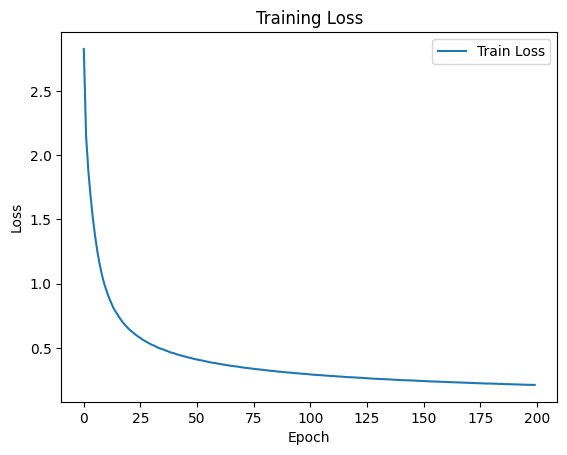

In [15]:
# Plot epoch-wise training loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

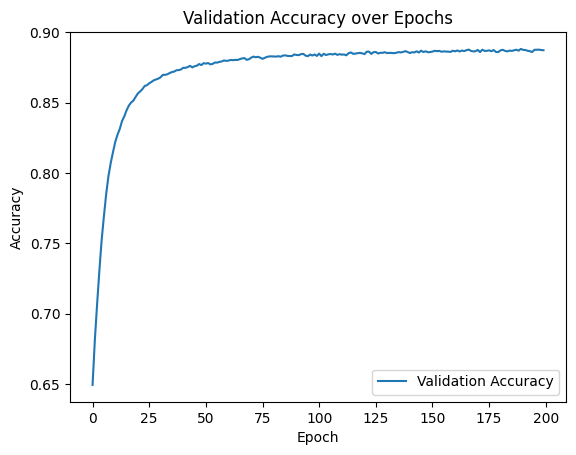

In [16]:
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [17]:
# Save the model
torch.save(model.state_dict(),'transformer_model.pth')

In [18]:
# Load the state dictionary from the saved file

# model.load_state_dict(torch.load('transformer_model.pth'))


Test_accuracy = compute_accuracy(model, dataloaders.test_loader)

print(f"Test Accuracy: {Test_accuracy:.5f}")

Test Accuracy: 0.88600


In [19]:
# Evaluate on test set
test_bleu_score = evaluate(model, dataloaders.test_loader,20)
print(f"Test BLEU Score: {test_bleu_score:.4f}")

src:  ! I go there every year. "
trg:  J ' y vais tous les ans. "
pred: ! J ' y vais chaque année. "
src:  ! We often eat raw fish. "
trg:  Nous mangeons souvent du poisson cru. "
pred: ! Nous mangeons souvent du poisson cru. "
src:  ! I ' m sorry I hurt Tom. "
trg:  Je suis désolé d ' avoir blessé Tom. "
pred: ! Je suis désolé d ' avoir blessé Tom. "
Test BLEU Score: 46.9432
